In [109]:
%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Saving as a scenario

In [110]:
!ls -ltrh ../mat/*

-rw-r--r--  1 laurentperrinet  staff    56M Nov 27 15:34 ../mat/master.npy
-rw-r--r--  1 laurentperrinet  staff   731K Nov 27 16:11 ../mat/line_fresnelastique.npy
-rw-r--r--  1 laurentperrinet  staff   731K Nov 27 16:11 ../mat/line_fresnelastique_chirp.npy
-rw-r--r--  1 laurentperrinet  staff   731K Nov 27 16:11 ../mat/line_fresnelastique_choc.npy
-rw-r--r--  1 laurentperrinet  staff   104K Nov 27 16:15 ../mat/line_vague_dense.npy
-rw-r--r--  1 laurentperrinet  staff   119K Nov 27 16:15 ../mat/line_vague_solo.npy
-rw-r--r--  1 laurentperrinet  staff   731K Nov 27 16:27 ../mat/line_geometry.npy


In [115]:
%%writefile ../scenario_line_master.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np
import os

def master(e, filename):
    if e.structure: N_lame = e.N_lame-e.struct_N
    else: N_lame = e.N_lame

    def montage(z, z_in):
        z_out = z.copy()
        z_s = z_in.copy()
        #print (z_out[0, 0], z_out[-1, 0], z_s[0, 0], z_s[-1, 0])
        z_s[:, 0] += z_out[-1, 0] #+ 1./e.desired_fps # increment the time on the new array
        #print (z_out.shape, z_s.shape, z_s[0, 0], z_s[-1, 0])
        return np.vstack((z_out, z_s))

    def revert(z_in):
        z_s = z_in.copy()
        z_s[:, 1:] = z_s[:, 1:][:, ::-1]
        return z_s

    def mirror(z_in):
        z_s = z_in.copy()
        z_s[:, 1:] = -z_s[:, 1:]
        return z_s

    def interleave(z_1, z_2):
        z_s_1 = z_1.copy()
        z_s_2 = z_2.copy()
        z_s_1[:, 1::2] = z_s_2[:, 1::2]
        return z_s_1
            
    matpath = 'mat/'
    z_s = {}
    for scenario in ['line_vague_dense', 'line_vague_solo', 'line_fresnelastique',
                    'line_fresnelastique_choc', 'line_fresnelastique_chirp', 'line_geometry']:
        z_s[scenario] = np.load(os.path.join(matpath, scenario + '.npy'))
    
    ###########################################################################
    burnout_time = 4.
    z = np.zeros((1, N_lame+1)) # zero at zero
    z = np.vstack((z, np.hstack((np.array(burnout_time), np.zeros(N_lame) ))))
    for _ in range(3):
        ###########################################################################
        z = montage(z, z_s['line_vague_dense'])
        ###########################################################################
        z = montage(z, z_s['line_geometry'])
        ###########################################################################
        z = montage(z, z_s['line_vague_solo'])
        z = montage(z, revert(z_s['line_vague_solo']))
        ###########################################################################
        z = montage(z, z_s['line_fresnelastique'])
        z = montage(z, mirror(z_s['line_fresnelastique']))
        z = montage(z, z_s['line_fresnelastique_chirp'])
        z = montage(z, z_s['line_fresnelastique_choc'])
        ###########################################################################
        z = montage(z, z_s['line_fresnelastique'])
        z = montage(z, interleave(z_s['line_fresnelastique'], mirror(z_s['line_fresnelastique'])))
        z = montage(z, interleave(z_s['line_fresnelastique_chirp'], mirror(z_s['line_fresnelastique_choc'])))
        z = montage(z, interleave(z_s['line_fresnelastique_choc'], mirror(z_s['line_fresnelastique_chirp'])))
        ###########################################################################
        z = montage(z, z_s['line_vague_dense'])
    
    ###########################################################################
    # save the file
    np.save(filename, z)

        

if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
        
    filename='mat/master.npy'
    
    e = el.EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=False, filename=filename)

    if mode == 'writer':
        master(e, filename)
    else:
        # running the code
        el.main(e)


Overwriting ../scenario_line_master.py


In [116]:
%cd ..
%run  scenario_line_master.py writer
%cd posts

/Users/laurentperrinet/pool/Dropbox/py-elasticite
/Users/laurentperrinet/pool/Dropbox/py-elasticite/posts


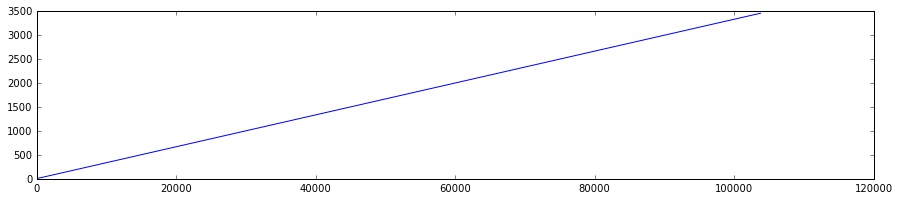

In [117]:
z = np.load('../mat/master.npy')
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(z[:, 0])

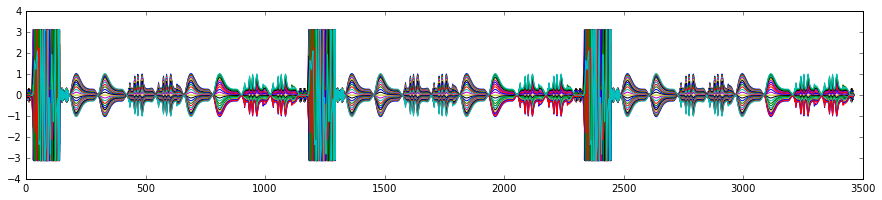

In [118]:
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(z[:, 0], z[:, 1:])

## git


In [119]:
#! git add 2015-11-26*
!git s

 M ../mat/master.npy
 M "2015-11-26 \303\251lasticit\303\251 - sc\303\251nario montage.ipynb"
 M ../scenario_line_master.py
?? "2015-11-02 \303\251lasticit\303\251 expansion en miroir - exploration param\303\250tres_conflict-20151125-105824.ipynb"
?? "2015-11-02 \303\251lasticit\303\251 expansion en miroir - principes_conflict-20151123-174335.ipynb"
?? "2015-11-17 \303\251lasticit\303\251 expansion en miroir - dynamique d'un point focal2.ipynb"
?? "2015-11-17 \303\251lasticit\303\251 expansion en miroir - dynamique d'un point focal_conflict-20151123-174338.ipynb"
?? "2015-11-27 \303\251lasticit\303\251, geometrie.ipynb"
?? ../scenario_line_fresnel_conflict-20151123-162407.py
?? ../scenario_line_geometry.py
?? ../src/elasticite_conflict-20151123-173759.py


In [120]:
!git commit -am' scenario master '

[master a3b70bb]  scenario master
 3 files changed, 13 insertions(+), 10 deletions(-)
 rewrite mat/master.npy (69%)


In [121]:
! git push

Counting objects: 7, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 14.06 MiB | 2.00 MiB/s, done.
Total 7 (delta 5), reused 0 (delta 0)
To git@git.framasoft.org:laurentperrinet/elasticte.git
   e3fcdc5..a3b70bb  master -> master
